In [105]:
import timm
import torch
import dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd

In [106]:
resnet50 = timm.create_model('resnet50', pretrained=True, num_classes=2)
vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

resnet50.eval()
vit.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [107]:
ds_train, ds_valid, class_weights = dataset.get_dataset('data/oxford_pets')

dl_valid = DataLoader(ds_valid, batch_size=32, shuffle=False, num_workers=5)

In [108]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dl_valid:
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Exibindo a acurácia
accuracy = 100 * correct / total
print(f'Acurácia do modelo: {accuracy:.2f}%')

Acurácia do modelo: 57.52%


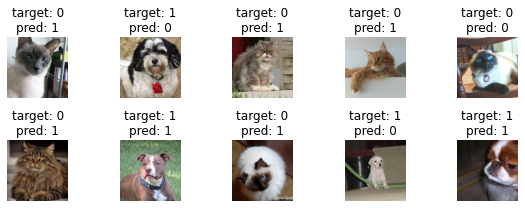

In [109]:
fig, axs = plt.subplots(2, 5, figsize=(8,3))
axs = axs.reshape(-1)
for idx in range(10):
    img, target = ds_valid[idx^2]
    with torch.no_grad():
        scores = resnet50(img.unsqueeze(0))
        pred = torch.argmax(scores)
    axs[idx].imshow(dataset.unormalize(img))
    axs[idx].set_title(f'target: {target}\npred: {pred}')
    axs[idx].set_axis_off()
plt.tight_layout()

In [110]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dl_valid:
        outputs = vit(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Exibindo a acurácia
accuracy = 100 * correct / total
print(f'Acurácia do modelo: {accuracy:.2f}%')

Acurácia do modelo: 41.05%


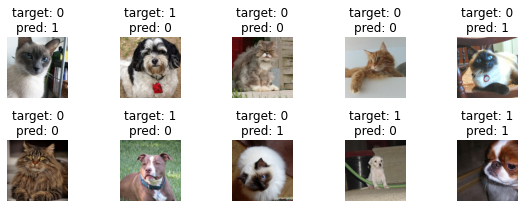

In [111]:
fig, axs = plt.subplots(2, 5, figsize=(8,3))
axs = axs.reshape(-1)
for idx in range(10):
    img, target = ds_valid[idx^2]
    with torch.no_grad():
        scores = vit(img.unsqueeze(0))
        pred = torch.argmax(scores)
    axs[idx].imshow(dataset.unormalize(img))
    axs[idx].set_title(f'target: {target}\npred: {pred}')
    axs[idx].set_axis_off()
plt.tight_layout()

## 10% de oclusão

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


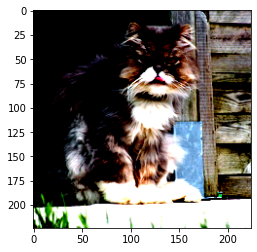

In [112]:
plt.imshow(ds_valid[0][0].permute(1,2,0))

In [113]:
def img_process(img):
    img_processed = img.permute(1,2,0)

    bbox = [76, 76, 147, 147]
    patch = img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    
    # Média de intensidade
    color = torch.mean(patch)
    # Substituição dos valores
    img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]] = color

    img_processed = img_processed.permute(2,0,1)

    return img_processed

def imgs_p(imgs):
    imgs_processed = []
    
    for img in imgs:
        img = img_process(img)
        imgs_processed.append(img)

    imgs_list = torch.stack(imgs_processed)
    return imgs_list


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


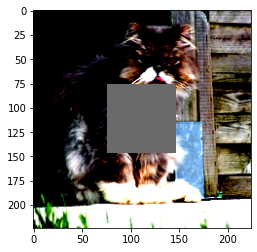

In [114]:
for images, labels in dl_valid:
    images = imgs_p(images)
    plt.imshow(images[0].permute(1,2,0))
    break

In [115]:
correct_resnet = 0
correct_vit = 0
total = 0

with torch.no_grad():
    for images, labels in dl_valid:
        images = imgs_p(images)

        outputs_resnet = resnet50(images)
        outputs_vit = vit(images)
        
        _, predicted_resnet = torch.max(outputs_resnet.data, 1)
        _, predicted_vit = torch.max(outputs_vit.data, 1)
        
        total += labels.size(0)

        correct_resnet += (predicted_resnet == labels).sum().item()
        correct_vit += (predicted_vit == labels).sum().item()

# Exibindo a acurácia
accuracy_resnet = 100 * correct_resnet / total
accuracy_vit = 100 * correct_vit / total

print(f'Acurácia do modelo ResNet50: {accuracy_resnet:.2f}%')
print(f'Acurácia do modelo ViT: {accuracy_vit:.2f}%')

Acurácia do modelo ResNet50: 57.59%
Acurácia do modelo ViT: 44.66%


## 30% de Oclusão

In [116]:
def img_process(img):
    img_processed = img.permute(1,2,0)

    bbox = [50, 50, 151, 151]
    patch = img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    
    # Média de intensidade
    color = torch.mean(patch)
    # Substituição dos valores
    img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]] = color

    img_processed = img_processed.permute(2,0,1)

    return img_processed

def imgs_p(imgs):
    imgs_processed = []
    
    for img in imgs:
        img = img_process(img)
        imgs_processed.append(img)

    imgs_list = torch.stack(imgs_processed)
    return imgs_list


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


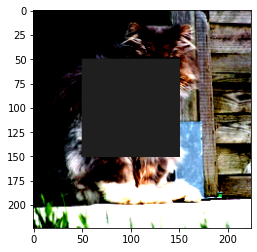

In [117]:
for images, labels in dl_valid:
    images = imgs_p(images)
    plt.imshow(images[0].permute(1,2,0))
    break

In [118]:
correct_resnet = 0
correct_vit = 0
total = 0

with torch.no_grad():
    for images, labels in dl_valid:
        images = imgs_p(images)

        outputs_resnet = resnet50(images)
        outputs_vit = vit(images)
        
        _, predicted_resnet = torch.max(outputs_resnet.data, 1)
        _, predicted_vit = torch.max(outputs_vit.data, 1)
        
        total += labels.size(0)

        correct_resnet += (predicted_resnet == labels).sum().item()
        correct_vit += (predicted_vit == labels).sum().item()

# Exibindo a acurácia
accuracy_resnet = 100 * correct_resnet / total
accuracy_vit = 100 * correct_vit / total

print(f'Acurácia do modelo ResNet50: {accuracy_resnet:.2f}%')
print(f'Acurácia do modelo ViT: {accuracy_vit:.2f}%')

Acurácia do modelo ResNet50: 56.84%
Acurácia do modelo ViT: 44.79%


## 60% de Oclusão

In [119]:
def img_process(img):
    img_processed = img.permute(1,2,0)

    bbox = [25, 25, 199, 199]
    patch = img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    
    # Média de intensidade
    color = torch.mean(patch)
    # Substituição dos valores
    img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]] = color

    img_processed = img_processed.permute(2,0,1)

    return img_processed

def imgs_p(imgs):
    imgs_processed = []
    
    for img in imgs:
        img = img_process(img)
        imgs_processed.append(img)

    imgs_list = torch.stack(imgs_processed)
    return imgs_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


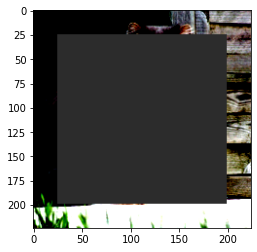

In [120]:
for images, labels in dl_valid:
    images = imgs_p(images)
    plt.imshow(images[0].permute(1,2,0))
    break

In [121]:
correct_resnet = 0
correct_vit = 0
total = 0

with torch.no_grad():
    for images, labels in dl_valid:
        images = imgs_p(images)

        outputs_resnet = resnet50(images)
        outputs_vit = vit(images)
        
        _, predicted_resnet = torch.max(outputs_resnet.data, 1)
        _, predicted_vit = torch.max(outputs_vit.data, 1)
        
        total += labels.size(0)

        correct_resnet += (predicted_resnet == labels).sum().item()
        correct_vit += (predicted_vit == labels).sum().item()

# Exibindo a acurácia
accuracy_resnet = 100 * correct_resnet / total
accuracy_vit = 100 * correct_vit / total

print(f'Acurácia do modelo ResNet50: {accuracy_resnet:.2f}%')
print(f'Acurácia do modelo ViT: {accuracy_vit:.2f}%')

Acurácia do modelo ResNet50: 56.30%
Acurácia do modelo ViT: 48.33%


## 80% de Oclusão

In [122]:
def img_process(img):
    img_processed = img.permute(1,2,0)

    bbox = [12, 12, 212, 212]
    patch = img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    
    # Média de intensidade
    color = torch.mean(patch)
    # Substituição dos valores
    img_processed[bbox[0]:bbox[2], bbox[1]:bbox[3]] = color

    img_processed = img_processed.permute(2,0,1)

    return img_processed

def imgs_p(imgs):
    imgs_processed = []
    
    for img in imgs:
        img = img_process(img)
        imgs_processed.append(img)

    imgs_list = torch.stack(imgs_processed)
    return imgs_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


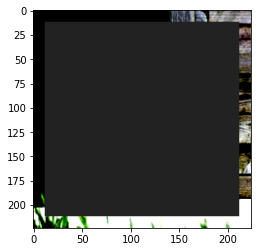

In [123]:
for images, labels in dl_valid:
    images = imgs_p(images)
    plt.imshow(images[0].permute(1,2,0))
    break

In [124]:
correct_resnet = 0
correct_vit = 0
total = 0

with torch.no_grad():
    for images, labels in dl_valid:
        images = imgs_p(images)

        outputs_resnet = resnet50(images)
        outputs_vit = vit(images)
        
        _, predicted_resnet = torch.max(outputs_resnet.data, 1)
        _, predicted_vit = torch.max(outputs_vit.data, 1)
        
        total += labels.size(0)

        correct_resnet += (predicted_resnet == labels).sum().item()
        correct_vit += (predicted_vit == labels).sum().item()

# Exibindo a acurácia
accuracy_resnet = 100 * correct_resnet / total
accuracy_vit = 100 * correct_vit / total

print(f'Acurácia do modelo ResNet50: {accuracy_resnet:.2f}%')
print(f'Acurácia do modelo ViT: {accuracy_vit:.2f}%')

Acurácia do modelo ResNet50: 51.33%
Acurácia do modelo ViT: 52.21%


In [127]:
dataFile = pd.read_csv('info.csv')
df_long = pd.melt(dataFile, id_vars=['name'], var_name='oclusao', value_name='accuracy')


In [128]:
fig = px.bar(df_long, x='name', y='accuracy', color='oclusao', barmode='group',
             labels={'name': 'Modelos', 'accuracy': 'Acurácia (%)', 'oclusao': 'Oclusão'})
fig.show()